<a href="https://colab.research.google.com/github/helenatong/oc_p4_Anticipez_les_besoins_en_consommation_de_batiments/blob/main/cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

---

## **Prérequis**
- Télécharger [le zip](https://drive.google.com/file/d/1Hw7gjd0cZQGi258_aosxPfC-RTSkcqJt/view?usp=sharing) dans Google Drive
- Modifier les chemins des fichiers (zip_path et extract_path) dans le code


---

 ## **Contexte et description du notebook**

L'objectif de Seattle est de devenir une ville neutre en émissions de carbone en 2050. La ville s'intéresse particulièrement aux consommations énergétiques et aux émissions de carbone des bâtiments qui ne sont pas destinés à l'habitation.

Néanmoins, ces 2 types de données ne sont pas disponibles pour tous les bâtiments. L'objectif ici est de prédire la consommation énergétique et l'émission de carbone.

De plus, un focus sera effectué sur si la variable ENERGYSTARScore Score joue un rôle important dans la précision des prédictions des émissions de carbone.

Les variables TotalGHGEmissions et SiteEnergyUseWN ont été choisies pour respectivement mesurer la consommation énergétique et l'émission de carbone.

---

## **Sommaire**

### **I. Installation et mise en place de l'environnement de travail**

### **II. Définitions des fonctions et des variables globales**

### **III. Analyse exploratoire**

### **IV. Nettoyage et imputation**

### **V. Analyse uni et bivariée**

# **I. Installation et mise en place de l'environnement de travail**

In [767]:
# Importation des librairies
import numpy as np
import pandas as pd

import zipfile
import os

import re

import sys

import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer

import datetime

In [768]:
# Informations sur l'environnement virtuel
print('Version des librairies :')
print('Python        : ' + sys.version)
print('NumPy         : ' + np.version.full_version)
print('Pandas        : ' + pd.__version__)
print('Matplotlib    : ' + mpl.__version__)
print('Seaborn       : ' + sns.__version__)

now  = datetime.datetime.now().isoformat()
print('Run date      : ' + now)

Version des librairies :
Python        : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
NumPy         : 1.25.2
Pandas        : 2.0.3
Matplotlib    : 3.7.1
Seaborn       : 0.13.1
Run date      : 2024-04-28T16:32:08.495671


In [769]:
# Configurations de l'affichages des données
pd.set_option('display.max_columns', None)

In [770]:
# Connexion au drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [771]:
# Verifier l'importation
df = pd.read_parquet('/content/drive/MyDrive/openclassrooms/project_list/project_4/data/2016_Building_Energy_Benchmarking.pq')
df.head(2)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,None,NaN,None,NaN,None,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.0,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,None,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,None,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.0,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,None,295.86,2.86


# **II. Définitions des fonctions et des variables globales**


In [772]:
ID = 'OSEBuildingID'

In [773]:
# Feature engineeing pour la variable YearsENERGYSTARCertified
def count_years_certified(year):
  if year == None:
    return 0
  elif len(year) == 4:
    return 1
  elif len(year) == 8:
    return 2
  else:
    power = year[8:]
    return((int(power) + 1)//4)

def last_year_certified(year):
    if year == None:
        return None
    elif len(year) in [4, 8]:
        return int(year[:4])
    else:
        return int(year[0] + year[2:5])

# **III. Analyse exploratoire**

##**Dimensions et statistiques générales des variables**

In [774]:
# Dimensions
nRow, nCol  = df.shape
print("NB DE LIGNES   :", nRow)
print("NB DE COLONNES :", nCol)

NB DE LIGNES   : 3376
NB DE COLONNES : 46


In [775]:
# Nom des colonnes
print("LISTE DES COLONNES :")
df.columns

LISTE DES COLONNES :


Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier

In [776]:
# Statistiques des variables qualitatives
print("VARIABLES QUALITATIVES :")
df.describe(exclude=[np.number])

VARIABLES QUALITATIVES :


,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,TaxParcelIdentificationNumber,Neighborhood,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,YearsENERGYSTARCertified,DefaultData,ComplianceStatus,Outlier
count,3376,3376,3376,3376,3376,3376,3376,3376,3367,3356,1679,596,119,3376,3376,32
unique,8,24,3362,3354,1,1,3268,19,466,56,50,44,43,2,4,2
top,NonResidential,Low-Rise Multifamily,Northgate Plaza,2600 SW Barton St,Seattle,WA,1625049001,DOWNTOWN,Multifamily Housing,Multifamily Housing,Parking,Retail Store,2016,False,Compliant,Low outlier
freq,1460,987,3,4,3376,3376,8,573,866,1667,976,110,14,3263,3211,23


In [777]:
# Statistiques des variables quantitatives
print("VARIABLES QUANTITATIVES :\n")
df.describe().apply(lambda s: s.apply('{0:.0f}'.format))

VARIABLES QUANTITATIVES :



,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,3376,3376,3360,3376,3376,3376,3376,3368,3376,3376,3376,3376,3356,1679,596,2533,3369,3370,3367,3367,3371,3370,3367,3367,3367,3367,3367,0,3367,3367
mean,21209,2016,98117,4,48,-122,1969,1,5,94834,8002,86832,79178,28444,11739,68,55,57,134,138,5403667,5276726,274596,1086639,3707612,13685,1368505,nan,120,1
std,12224,0,19,2,0,0,33,2,5,218838,32327,207940,201703,54393,29331,27,56,57,139,139,21610629,15938786,3912173,4352478,14850656,67098,6709781,nan,539,2
min,1,2016,98006,1,47,-122,1900,0,0,11285,0,3636,5656,0,0,1,0,0,0,-2,0,0,0,-33827,-115417,0,0,nan,-1,-0
25%,19991,2016,98105,3,48,-122,1948,1,2,28487,0,27756,25095,5000,2239,53,28,29,75,78,925129,970182,0,187423,639487,0,0,nan,9,0
50%,23112,2016,98115,4,48,-122,1975,1,4,44175,0,43216,39894,10664,5043,75,39,41,96,101,1803753,1904452,0,345130,1177583,3238,323754,nan,34,1
75%,25994,2016,98122,7,48,-122,1997,1,5,90992,0,84276,76200,26640,10139,90,60,64,144,148,4222455,4381429,0,829318,2829632,11890,1189034,nan,94,1
max,50226,2016,98272,7,48,-122,2015,111,99,9320156,512608,9320156,9320156,686750,459748,100,834,834,2620,2620,873923712,471613856,134943456,192577488,657074389,2979090,297909000,nan,16871,34


In [778]:
# Type des variables
print("TYPE DES VARIABLES :\n")
df.dtypes

TYPE DES VARIABLES :



OSEBuildingID                        int64
DataYear                             int64
BuildingType                        object
PrimaryPropertyType                 object
PropertyName                        object
Address                             object
City                                object
State                               object
ZipCode                            float64
TaxParcelIdentificationNumber       object
CouncilDistrictCode                  int64
Neighborhood                        object
Latitude                           float64
Longitude                          float64
YearBuilt                            int64
NumberofBuildings                  float64
NumberofFloors                       int64
PropertyGFATotal                     int64
PropertyGFAParking                   int64
PropertyGFABuilding(s)               int64
ListOfAllPropertyUseTypes           object
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64
SecondLarge

La majorité des types ont été bien importés sauf pour :
- YearsENERGYSTARCertified
- ZipCode, CouncilDistrictCode

**DOUBLONS ET VALEURS MANQUANTES**

In [779]:
# Doublons selon l'ID du bâtiment
print('Nb de doublons: ', df[ID].isna().sum(axis=0))

Nb de doublons:  0


VALEURS MANQUANTES :
                                   NB      %
Comments                         3376  100.0
Outlier                          3344   99.0
YearsENERGYSTARCertified         3257   96.0
ThirdLargestPropertyUseType      2780   82.0
ThirdLargestPropertyUseTypeGFA   2780   82.0
SecondLargestPropertyUseTypeGFA  1697   50.0
SecondLargestPropertyUseType     1697   50.0
ENERGYSTARScore                   843   25.0
LargestPropertyUseTypeGFA          20    1.0
LargestPropertyUseType             20    1.0
NaturalGas(kBtu)                    9    0.0
SiteEUIWN(kBtu/sf)                  6    0.0
TotalGHGEmissions                   9    0.0
ComplianceStatus                    0    0.0
SiteEUI(kBtu/sf)                    7    0.0
SourceEUI(kBtu/sf)                  9    0.0
NaturalGas(therms)                  9    0.0
SourceEUIWN(kBtu/sf)                9    0.0
SiteEnergyUse(kBtu)                 5    0.0
DefaultData                         0    0.0
SteamUse(kBtu)                    

Text(0.5, 1.0, 'Matrice des valeurs manquantes\n')

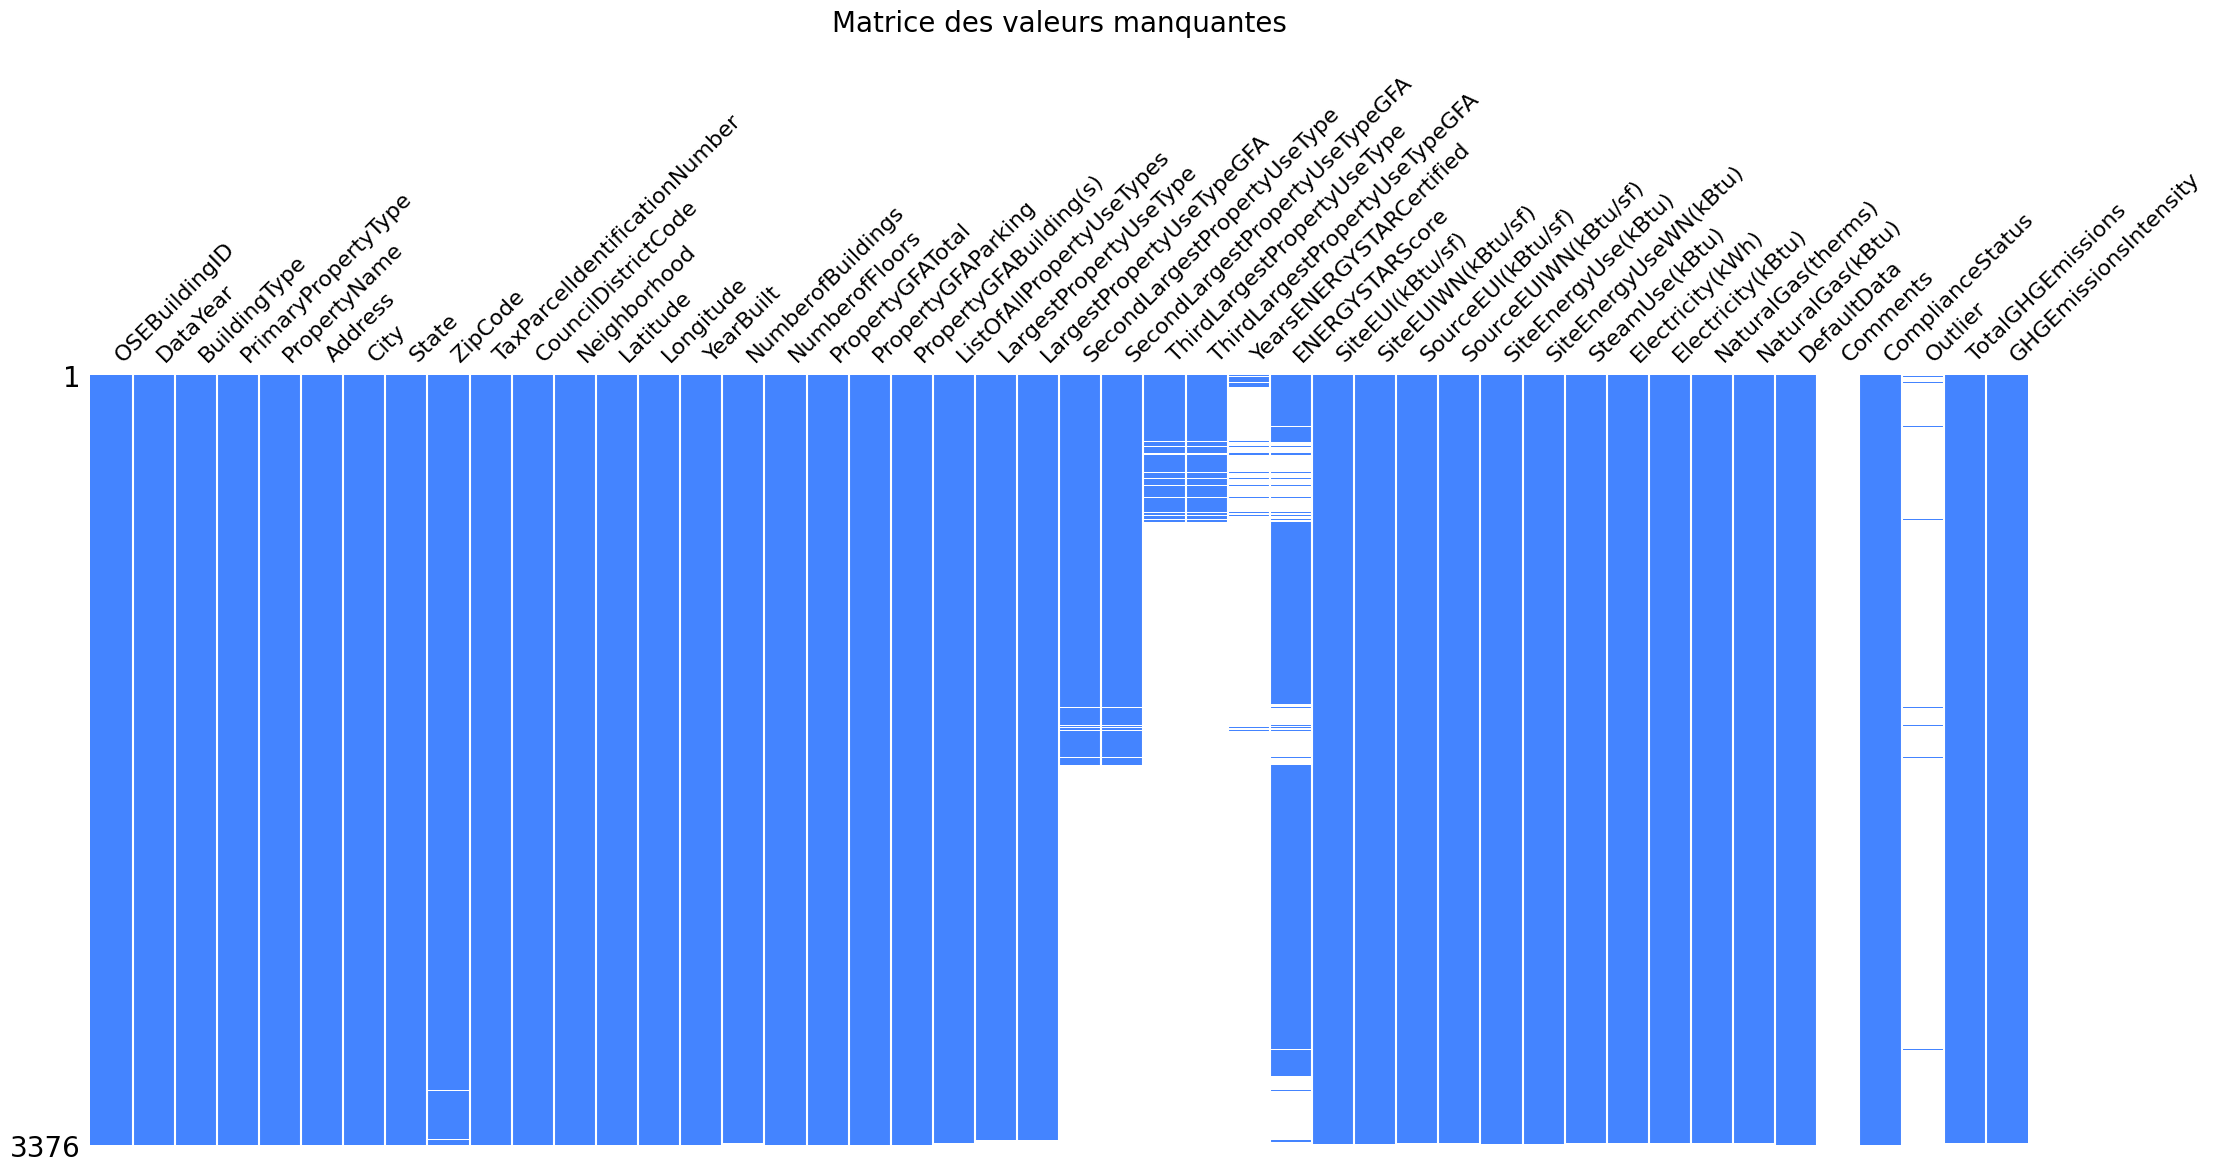

In [780]:
# Valeurs manquantes
missing_values_count = df.isna().sum()
missing_values_percent = round(df.isna().mean() * 100, 0)
missing_data = pd.concat([missing_values_count, missing_values_percent], axis = 1)
missing_data.columns = ['NB', '%']
print("VALEURS MANQUANTES :\n", missing_data.sort_values(by = '%', ascending = False ), sep = '', end = '\n\n')

# Représentons graphiquement les données manquantes
msno.matrix(df,
            color=(0.27, 0.52, 1.0),
            sort="descending",
            sparkline = False,
           ).set_title("Matrice des valeurs manquantes\n", fontsize = 20)

# **IV. Nettoyage et imputation**

J'ai choisi les variables suivantes pour prédire les emissions de carbones et la consommation énergétique:

- **Emission de carbone: TotalGHGEmissions** :

Quantité totale d'émission de gaz à effet de serre, y compris le dioxyde de carbone, le méthane et l'oxyde nitreux, rejetée dans l'atmosphère à la suite de la consommation d'énergie sur le site, mesurée en tonne d'équivalent dioxyde de carbone.

- **Consommation énergétique: SiteEnergyUse(kBtu)** :

Consommation énergétique sur site, toutes énergies confondues. En Kilo d'unités thermiques britanniques

Dans la partie nettoyage, je vais donc choisir des variables explicatives pour prédire ces 2 variables cibles.


##**A. Nettoyage**

**CONSERVER LES BATIMENTS NON RESIDENTIELS**

In [781]:
# Lister les types de bâtiments
df['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

In [782]:
# Conserver uniquement les bâtiments non résidentiels
non_residential_buildings = [b for b in df['BuildingType'].unique() if 'nonresidential' in b.lower()]
df = df.loc[df['BuildingType'].isin(non_residential_buildings)]

In [783]:
# Vérifier l'usage principal des batiments
df['LargestPropertyUseType'].value_counts()

LargestPropertyUseType
Office                                                  495
Non-Refrigerated Warehouse                              199
Retail Store                                             97
Other                                                    91
Hotel                                                    76
Worship Facility                                         71
Distribution Center                                      54
Supermarket/Grocery Store                                41
Medical Office                                           41
K-12 School                                              39
Other - Recreation                                       31
Parking                                                  29
Self-Storage Facility                                    27
Residence Hall/Dormitory                                 22
Other - Entertainment/Public Assembly                    21
Senior Care Community                                    20
College/Universit

In [784]:
# Retirer les bâtiments indiqués comme résidentiel
residential_use=['Residence Hall/Dormitory', 'Multifamily Housing', 'Residential Care Facility', 'Other - Lodging/Residential']
df = df.loc[~df['LargestPropertyUseType'].isin(residential_use)]

**RETIRER LES BATIMENTS ATYPIQUES**

In [785]:
# Le statut de conformité indique si un bâtiment satisfait aux exigences de référencement énergétique pour l'année en cours
df['ComplianceStatus'].value_counts()

ComplianceStatus
Compliant                       1476
Non-Compliant                     17
Error - Correct Default Data      13
Missing Data                       1
Name: count, dtype: int64

In [786]:
## Je conserve uniquement les bâtiments Compliant
df = df.loc[df['ComplianceStatus'] == 'Compliant']

# Je supprime la colonne car elle ne contient plus d'informations intéressantes
df.drop(columns=['ComplianceStatus'], inplace=True)

In [787]:
# Indique si les bâtiments sont des outliers
print(df['Outlier'].value_counts())

Series([], Name: count, dtype: int64)


In [788]:
# Les batiments outilier ont été filtrés en amont
# Je supprime la colonne
df.drop(columns=['Outlier'], inplace=True)

**RETIRER LA COLONNE VIDE**

In [789]:
# Retirer la colonne vide
df.drop(columns='Comments', inplace=True)

**RETIRER LES VARIABLES PEU PERTINENTES**

In [790]:
# DefaultData indique si au moins une variable a été imputée automatiquement pour le bâtiment
## Vérification des valeurs pour la qualité de la base
percentage_true = df['DefaultData'].mean() * 100
print(f"% de bâtiments dont au moins une valeur a été imputée: {percentage_true:.2f}%")

# Je supprime car l'information n'est pas pertinente
df.drop(columns=['DefaultData'], inplace=True)

% de bâtiments dont au moins une valeur a été imputée: 0.00%


**SUPPRIMER LES VARIABLES DONT L'INFORMATION EST REDONDANTE**

In [791]:
# Pour identifier un batiment de manière unique, j'ai choisi OSEBuildingID
df.drop(columns=['PropertyName', 'TaxParcelIdentificationNumber'], inplace=True)

In [792]:
# Pour identifier la localisation, j'ai choisi Neighborhood:
## Pour limiter le nombre de variables, j'ai favorisé Neighborhood par rapport au couple (Latitude,Longitude) malgré une perte de précision
## Neighborhood peut être choisi car tous les bâtiments sont situés à Seattle
## Il manque des valeurs pour ZipCode donc j'ai favorisé Neighborhood
df.drop(columns=['Address', 'City', 'State', 'ZipCode', 'CouncilDistrictCode', 'Latitude', 'Longitude'], inplace=True)

In [793]:
# Pour mesurer les émissions de carbones, j'ai choisi TotalGHGEmissions:
## Car GHGEmissionsIntensity ne prend pas en compte la surface totale du bâtiment
df.drop(columns=['GHGEmissionsIntensity'], inplace=True)

In [794]:
# Pour mesurer la consommation énergétique, j'ai choisi SiteEnergyUse(kBtu):
## Car SourceEUIWN et SourceEUI prennent en compte les pertes liées à la production et au transport
## Car SiteEUI(kBtu/sf) et SiteEUIWN(kBtu/sf) ne prennent pas en compte la surface totale du bâtiment
## Car même si SiteEnergyUseWN(kBtu) retire les effets des variations climatique, les bâtiments sont dans la même ville avec un climat similaire
df.drop(columns=['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)'], inplace=True)

In [795]:
# Pour mesurer les variables features, j'ai choisi les variables mesurées en kBtu:
## Car l'unité sera uniforme
df.drop(columns=['Electricity(kWh)', 'NaturalGas(therms)'], inplace=True)

In [796]:
# On a déjà les 3 principaux utilisations de la propriété, ListOfAllPropertyUseTypes n'apporte pas plus d'information
## On regarde si on ne perd pas d'information
missing_value = [(col, df[col].isna().sum()) for col in ['ListOfAllPropertyUseTypes', 'LargestPropertyUseType']]
print("missing values:\n", missing_value)

missing values:
 [('ListOfAllPropertyUseTypes', 0), ('LargestPropertyUseType', 4)]


In [797]:
# Il manque des valeur, on regarde les valeurs à replacer
print(df[df['LargestPropertyUseType'].isna()])

# On remplace les valeurs manquantes et on supprime la colonne ListOfAllPropertyUseTypes
df.loc[df['OSEBuildingID'] == 496, 'LargestPropertyUseType'] = 'Self-Storage Facility'
df.loc[df['OSEBuildingID'] == 21103, 'LargestPropertyUseType'] = 'Hotel'
df.loc[df['OSEBuildingID'] == 25568, 'LargestPropertyUseType'] = 'Office'
df.loc[df['OSEBuildingID'] == 25711, 'LargestPropertyUseType'] = 'Restaurant'
df.drop(columns=['ListOfAllPropertyUseTypes'], inplace=True)

      OSEBuildingID  DataYear    BuildingType          PrimaryPropertyType  \
353             496      2016  NonResidential        Self-Storage Facility   
1147          21103      2016  NonResidential                        Hotel   
2414          25568      2016  NonResidential  Small- and Mid-Sized Office   
2459          25711      2016  NonResidential                   Restaurant   

     Neighborhood  YearBuilt  NumberofBuildings  NumberofFloors  \
353       BALLARD       1946                2.0               2   
1147     DOWNTOWN       1910                1.0               8   
2414   LAKE UNION       2008                1.0               4   
2459     DOWNTOWN       1913                1.0               3   

      PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
353             111445                   0                  111445   
1147             61721                   0                   61721   
2414             48350                   0                   48

**FEATURE ENGINEERING**

In [798]:
# Je regarde s'il existe des valeurs abérantes
print(df['YearBuilt'].unique(), end='\n')
print(df['DataYear'].unique())

[1927 1996 1969 1926 1980 1999 1904 1998 1928 1922 2004 1930 1983 1907
 1916 1985 2001 1991 1978 1906 1994 1955 1961 1900 1954 1911 1973 1920
 1910 1982 1908 1959 2000 1997 1962 1970 2008 1965 1929 2010 1990 1938
 1986 2002 1923 2003 1941 2006 1915 1950 1958 1971 2007 1951 1964 1953
 1937 1966 1957 1968 1924 2005 1931 1972 1952 1914 1981 1989 1925 1976
 2009 1909 1988 1979 1947 1984 1956 1912 1977 1960 1945 1992 1963 1974
 1975 1946 1995 1967 1987 1949 1940 1932 1948 1993 1918 1905 1902 1921
 1939 1944 1917 1942 1903 2012 2013 1919 1901 1936 1913 1935 2011 2014
 2015]
[2016]


In [799]:
# Age du bâtiment qui remplace 2 variables et qui est plus explicite
df['BuildingAge'] = df['DataYear'] - df['YearBuilt']
df.drop(columns=['DataYear', 'YearBuilt'], inplace=True)
df['BuildingAge'].unique()

array([ 89,  20,  47,  90,  36,  17, 112,  18,  88,  94,  12,  86,  33,
       109, 100,  31,  15,  25,  38, 110,  22,  61,  55, 116,  62, 105,
        43,  96, 106,  34, 108,  57,  16,  19,  54,  46,   8,  51,  87,
         6,  26,  78,  30,  14,  93,  13,  75,  10, 101,  66,  58,  45,
         9,  65,  52,  63,  79,  50,  59,  48,  92,  11,  85,  44,  64,
       102,  35,  27,  91,  40,   7, 107,  28,  37,  69,  32,  60, 104,
        39,  56,  71,  24,  53,  42,  41,  70,  21,  49,  29,  67,  76,
        84,  68,  23,  98, 111, 114,  95,  77,  72,  99,  74, 113,   4,
         3,  97, 115,  80, 103,  81,   5,   2,   1])

In [800]:
# On regarde les valeurs
to_check = 'YearsENERGYSTARCertified'
print('raw:\n', df[to_check].unique(), end='\n\n')
print(df[to_check].dtypes) # Perte d'informations à cause du format de données

raw:
 [None '2016' '2014' '2012' '20172015' '2,0172E+39' '2,0102E+11'
 '2,0172E+11' '20162015' '2,0152E+19' '2,0122E+11' '2,0162E+35'
 '2,0162E+11' '2,0162E+19' '2,0162E+51' '2,0152E+11' '2,0142E+27'
 '2,0162E+15' '2,0172E+27' '2,0172E+23' '2,0152E+15' '2007' '2010'
 '2,0172E+19' '2,0172E+15' '2015' '2017' '2,0172E+35' '20092005'
 '2,0122E+15' '20112009' '2009' '2,0162E+23' '2,0162E+27' '20102008'
 '20162012' '2,0162E+31' '2,0142E+15' '2,0162E+59' '2011' '20172016'
 '2013' '20152012']

object


In [801]:
# Je peux déduire 2 informations:
## le nombre d'années où la certification a été obtenue
## la dernière année d'obtention du certificat

# Création des 2 nouvelles variables
df['LastYearENERGYSTARCertified'] = df['YearsENERGYSTARCertified'].apply(last_year_certified)
df['NbYearENERGYSTARCertified']   = df['YearsENERGYSTARCertified'].apply(count_years_certified)

# Vérifier la transformation
print(df['LastYearENERGYSTARCertified'].unique(), df['NbYearENERGYSTARCertified'].unique())

# Supprimer l'ancienne colonne
df.drop(columns=['YearsENERGYSTARCertified'], inplace=True)

[  nan 2016. 2014. 2012. 2017. 2010. 2015. 2007. 2009. 2011. 2013.] [ 0  1  2 10  3  5  9 13  7  4  6  8 15]


In [802]:
df.reset_index()

,index,OSEBuildingID,BuildingType,PrimaryPropertyType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,BuildingAge,LastYearENERGYSTARCertified,NbYearENERGYSTARCertified
0,0,1,NonResidential,Hotel,DOWNTOWN,1.0,12,88434,0,88434,Hotel,88434.0,None,NaN,None,NaN,60.0,7.226362e+06,2003882.00,3.946027e+06,1.276453e+06,249.98,89,NaN,0
1,1,2,NonResidential,Hotel,DOWNTOWN,1.0,11,103566,15064,88502,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,8.387933e+06,0.00,3.242851e+06,5.145082e+06,295.86,20,NaN,0
2,2,3,NonResidential,Hotel,DOWNTOWN,1.0,41,956110,196718,759392,Hotel,756493.0,None,NaN,None,NaN,43.0,7.258702e+07,21566554.00,4.952666e+07,1.493800e+06,2089.28,47,NaN,0
3,3,5,NonResidential,Hotel,DOWNTOWN,1.0,10,61320,0,61320,Hotel,61320.0,None,NaN,None,NaN,56.0,6.794584e+06,2214446.25,2.768924e+06,1.811213e+06,286.43,90,NaN,0
4,4,8,NonResidential,Hotel,DOWNTOWN,1.0,18,175580,62000,113580,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,75.0,1.417261e+07,0.00,5.368607e+06,8.803998e+06,505.01,36,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471,3370,50221,Nonresidential COS,Other,DELRIDGE NEIGHBORHOODS,1.0,1,18261,0,18261,Other - Recreation,18261.0,None,NaN,None,NaN,NaN,9.320821e+05,0.00,6.323620e+05,2.997200e+05,20.33,34,NaN,0
1472,3372,50223,Nonresidential COS,Other,DOWNTOWN,1.0,1,16000,0,16000,Other - Recreation,16000.0,None,NaN,None,NaN,NaN,9.502762e+05,0.00,3.965461e+05,5.537300e+05,32.17,12,NaN,0
1473,3373,50224,Nonresidential COS,Other,MAGNOLIA / QUEEN ANNE,1.0,1,13157,0,13157,Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimming Pool,0.0,NaN,5.765898e+06,0.00,1.792159e+06,3.973739e+06,223.54,42,NaN,0
1474,3374,50225,Nonresidential COS,Mixed Use Property,GREATER DUWAMISH,1.0,1,14101,0,14101,Other - Recreation,6601.0,Fitness Center/Health Club/Gym,6501.0,Pre-school/Daycare,484.0,NaN,7.194712e+05,0.00,3.488702e+05,3.706010e+05,22.11,27,NaN,0


**NETTOYAGE DES MODALITES QUALITATIVES**

In [803]:
# vérification de la cohérence des données
to_check = 'Neighborhood'
print('raw:\n', df[to_check].unique(), end='\n\n')

# harmoniser les données
mapping = {
  'North': 'NORTH',
  'Delridge': 'DELRIDGE',
  'DELRIDGE NEIGHBORHOODS': 'DELRIDGE',
  'Northwest': 'NORTHWEST',
  'Ballard': 'BALLARD',
  'Central': 'CENTRAL'
}

df[to_check] = df[to_check].replace(mapping)
print(f'updated values in {to_check} :\n', df[to_check].unique())

raw:
 ['DOWNTOWN' 'NORTHEAST' 'EAST' 'LAKE UNION' 'GREATER DUWAMISH' 'BALLARD'
 'NORTHWEST' 'MAGNOLIA / QUEEN ANNE' 'CENTRAL' 'SOUTHWEST' 'SOUTHEAST'
 'NORTH' 'DELRIDGE' 'North' 'Delridge' 'Ballard' 'Northwest' 'Central'
 'DELRIDGE NEIGHBORHOODS']

updated values in Neighborhood :
 ['DOWNTOWN' 'NORTHEAST' 'EAST' 'LAKE UNION' 'GREATER DUWAMISH' 'BALLARD'
 'NORTHWEST' 'MAGNOLIA / QUEEN ANNE' 'CENTRAL' 'SOUTHWEST' 'SOUTHEAST'
 'NORTH' 'DELRIDGE']


##**B. Imputation**

In [804]:
# Valeurs manquantes
missing_values_count = df.isna().sum()
missing_values_percent = round(df.isna().mean() * 100, 0)
missing_data = pd.concat([missing_values_count, missing_values_percent], axis = 1)
missing_data.columns = ['NB', '%']
missing_data = missing_data[missing_data['NB'] != 0]
print("VALEURS MANQUANTES :\n", missing_data.sort_values(by = '%', ascending = False ), sep = '', end = '\n\n')

VALEURS MANQUANTES :
                                   NB     %
LastYearENERGYSTARCertified      1385  94.0
ThirdLargestPropertyUseType      1148  78.0
ThirdLargestPropertyUseTypeGFA   1148  78.0
SecondLargestPropertyUseType      665  45.0
SecondLargestPropertyUseTypeGFA   665  45.0
ENERGYSTARScore                   515  35.0
LargestPropertyUseTypeGFA           4   0.0



In [805]:
# Pour LastYearENERGYSTARCertified l'absence de valeurs signifie que le bâtiment n'a jamais été certifié
df['LastYearENERGYSTARCertified'].fillna(0, inplace=True)

In [806]:
# L'absence de valeurs signifie que le bâtiment signifie qu'il n'y a pas de deuxieme ou troisieme usage
df['ThirdLargestPropertyUseType'].fillna('missing', inplace=True)
df['ThirdLargestPropertyUseTypeGFA'].fillna(0, inplace=True)

df['SecondLargestPropertyUseType'].fillna('missing', inplace=True)
df['SecondLargestPropertyUseTypeGFA'].fillna(0, inplace=True)

df['LargestPropertyUseType'].fillna("missing", inplace=True)

In [807]:
from sklearn.impute import KNNImputer

In [808]:
impute_knn = KNNImputer(n_neighbors=3)
columns_to_impute = ['ENERGYSTARScore', 'LargestPropertyUseTypeGFA']
df[columns_to_impute] = impute_knn.fit_transform(df[columns_to_impute])

# **V. Analyse uni et bivariée**

Pour résumé, j'ai choisi les variables à prédire TotalGHGEmissions et SiteEnergyUse(kBtu).

Les variables explicatives peuvent être catégorisées sous les labels suivants:

- **LA CONSOMMATION ENERGERIQUE** (SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu))
- **LE SCORE ENERGETIQUE** (ENERGYSTARScore, LastYearENERGYSTARCertified, NbYearENERGYSTARCertified)
- **LES CARACTERISTIQUES PHYSIQUES DU BATIMENT**
(NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking,
PropertyGFABuilding(s), LargestPropertyUseTypeGFA, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseTypeGFA)
- **LES USAGES** (BuildingType, PrimaryPropertyType, LargestPropertyUseType, SecondLargestPropertyUseType, ThirdLargestPropertyUseType)
- **LA LOCALISATION ET L'AGE** (Neighborhood, BuildingAge).


##**A. Analyse bivariée**

###**1. Variables qualitatives**

In [809]:
# Statistiques des variables qualitatives
print("VARIABLES QUALITATIVES :")
df.describe(exclude=[np.number])

VARIABLES QUALITATIVES :


,BuildingType,PrimaryPropertyType,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType
count,1476,1476,1476,1476,1476,1476
unique,3,19,13,51,48,39
top,NonResidential,Small- and Mid-Sized Office,DOWNTOWN,Office,missing,missing
freq,1395,286,338,484,665,1148


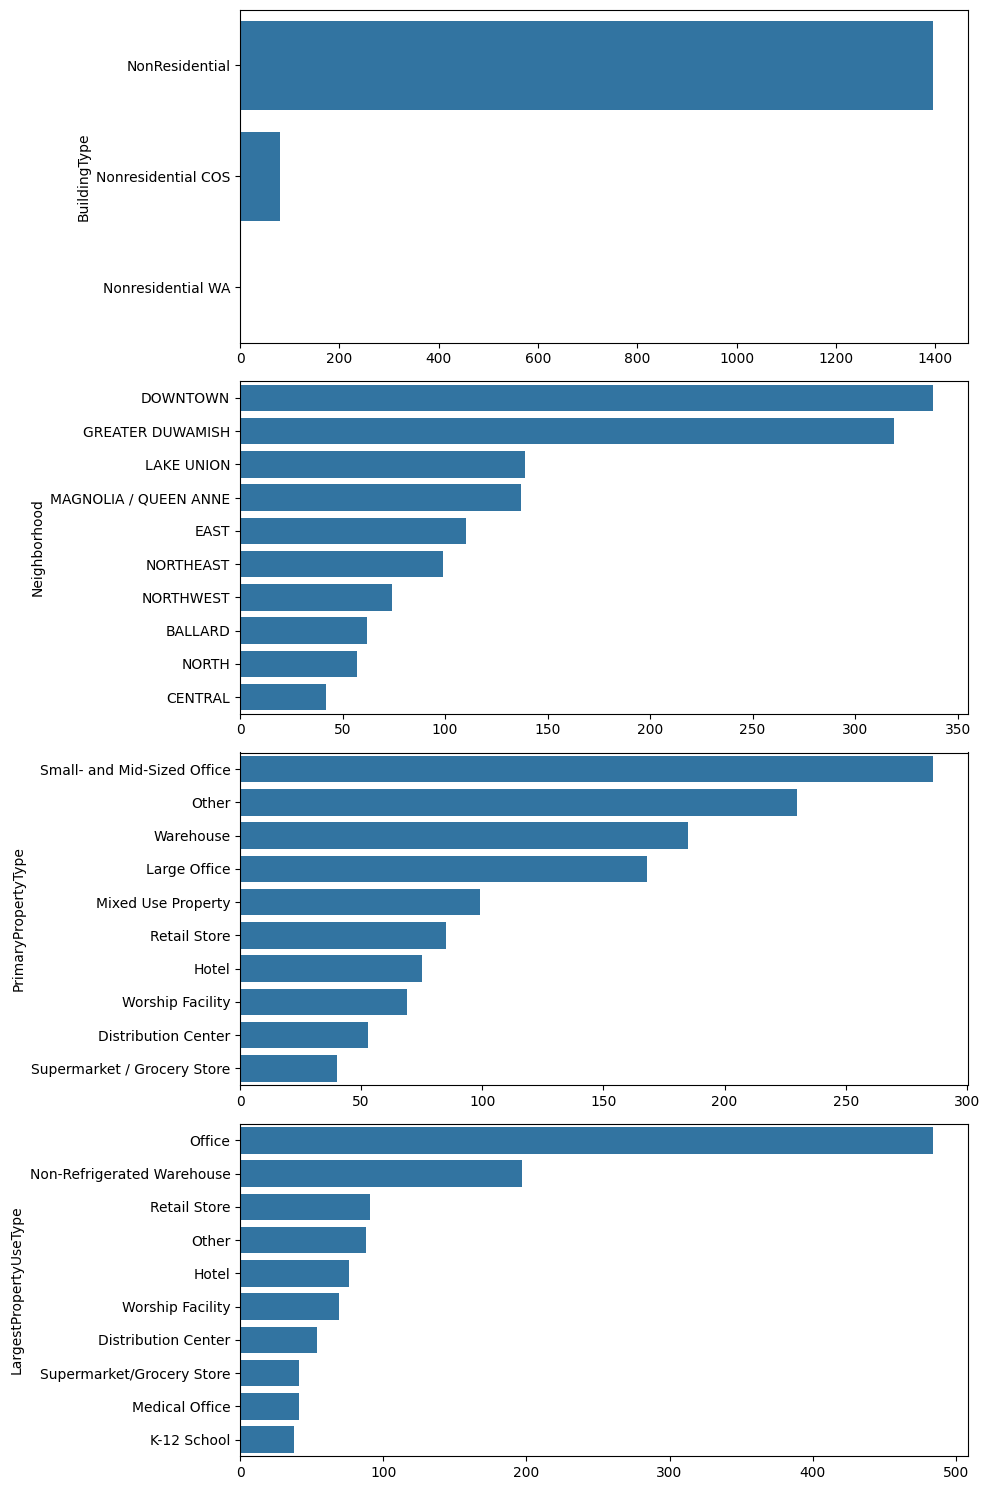

In [810]:
# TOP 10 des modalités de chaque variable qualitative
L = ['BuildingType', 'Neighborhood', 'PrimaryPropertyType', 'LargestPropertyUseType']
fig, axes = plt.subplots(nrows=len(L), ncols=1, figsize=(10,15))

for i, col in enumerate(L):
  df_graph = df[col].value_counts().sort_values(ascending=False)
  sns.barplot(x=df_graph[:10].values, y=df_graph[:10].index, ax=axes[i])

plt.tight_layout()
plt.show()

###**2. Variables quantitatives**

In [811]:
# Statistiques des variables quantitatives
print("VARIABLES QUANTITATIVES :\n")
df.describe().apply(lambda s: s.apply('{0:.0f}'.format))

VARIABLES QUANTITATIVES :



,OSEBuildingID,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,BuildingAge,LastYearENERGYSTARCertified,NbYearENERGYSTARCertified
count,1476,1476,1476,1476,1476,1476,1476,1476,1476,1476,1476,1476,1476,1476,1476,1476,1476,1476
mean,16263,1,4,112802,14246,98556,91936,19394,2919,62,7823348,514091,5550806,1711724,169,55,124,0
std,13760,1,7,190845,44525,166754,157439,49671,14139,26,19007112,5425482,13254506,5620035,583,33,485,1
min,1,0,0,11285,0,3636,5656,0,0,1,57133,0,-115417,0,-1,1,0,0
25%,601,1,1,28817,0,27900,25077,0,0,46,1223105,0,725989,0,20,28,0,0
50%,21142,1,2,47978,0,45853,41628,100,0,65,2687720,0,1711462,442087,49,51,0,0
75%,24582,1,4,103599,0,93569,90000,13678,0,83,7253381,0,5238197,1437831,142,86,0,0
max,50226,9,99,1952220,512608,1765970,1680937,441551,303910,100,293090784,134943456,274532495,138191238,12307,116,2017,15


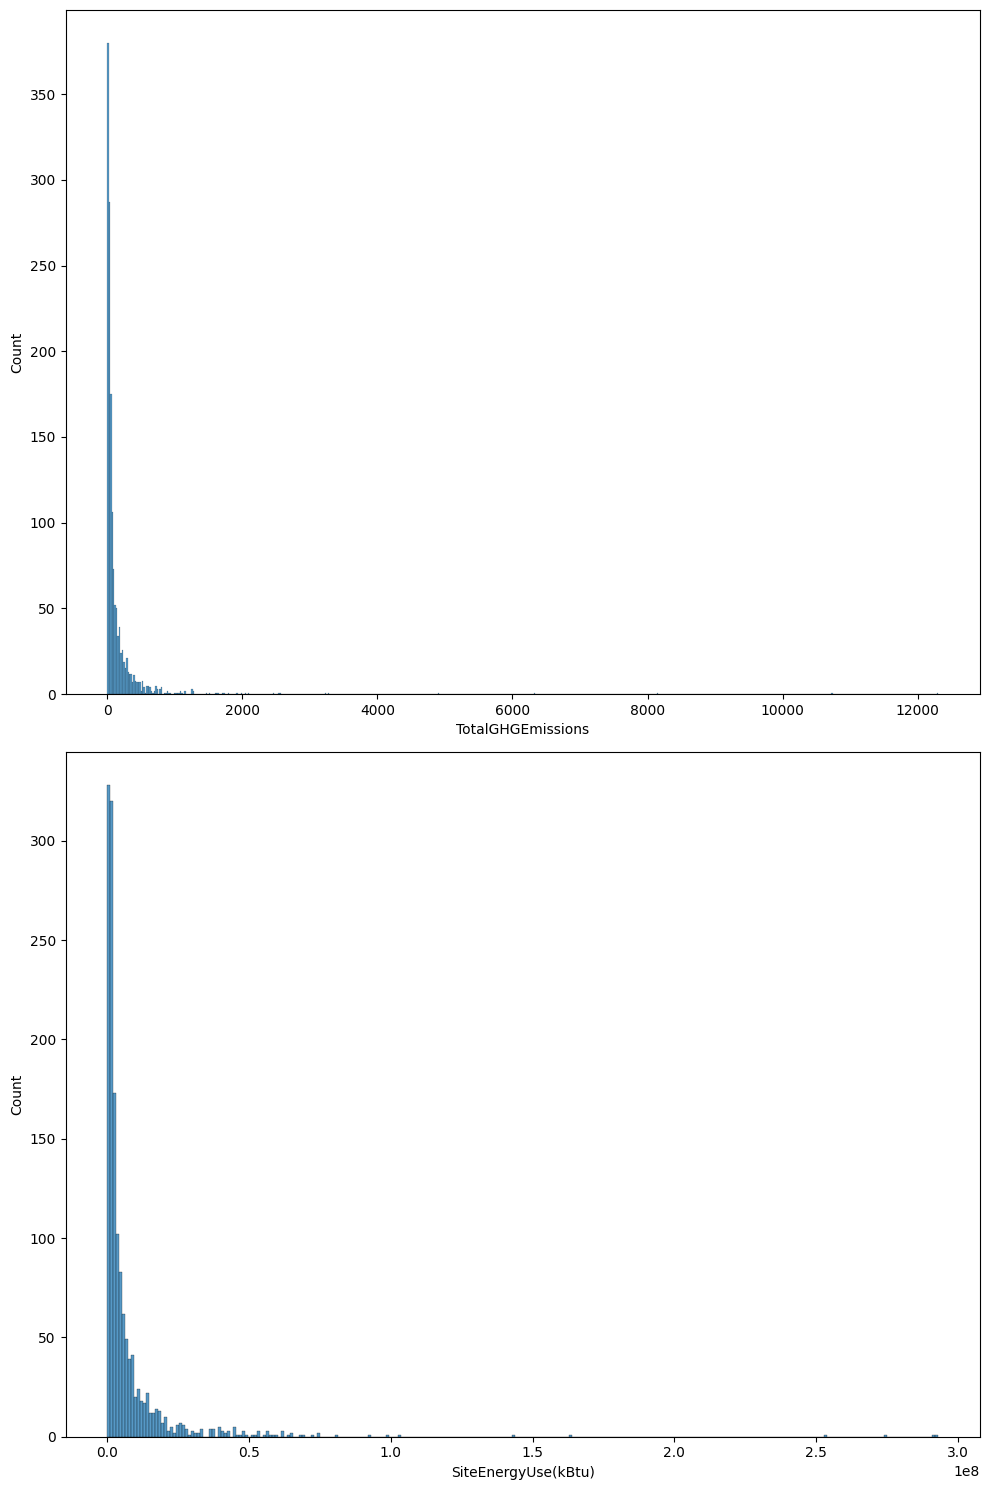

In [812]:
# Variables à prédire
L_num = ['TotalGHGEmissions', 'SiteEnergyUse(kBtu)']
fig, axes = plt.subplots(nrows=len(L_num), ncols=1, figsize=(10,15))

for i, col in enumerate(L_num):
  df_graph = df[col]
  sns.histplot(x=df_graph, ax=axes[i])

plt.tight_layout()
plt.show()

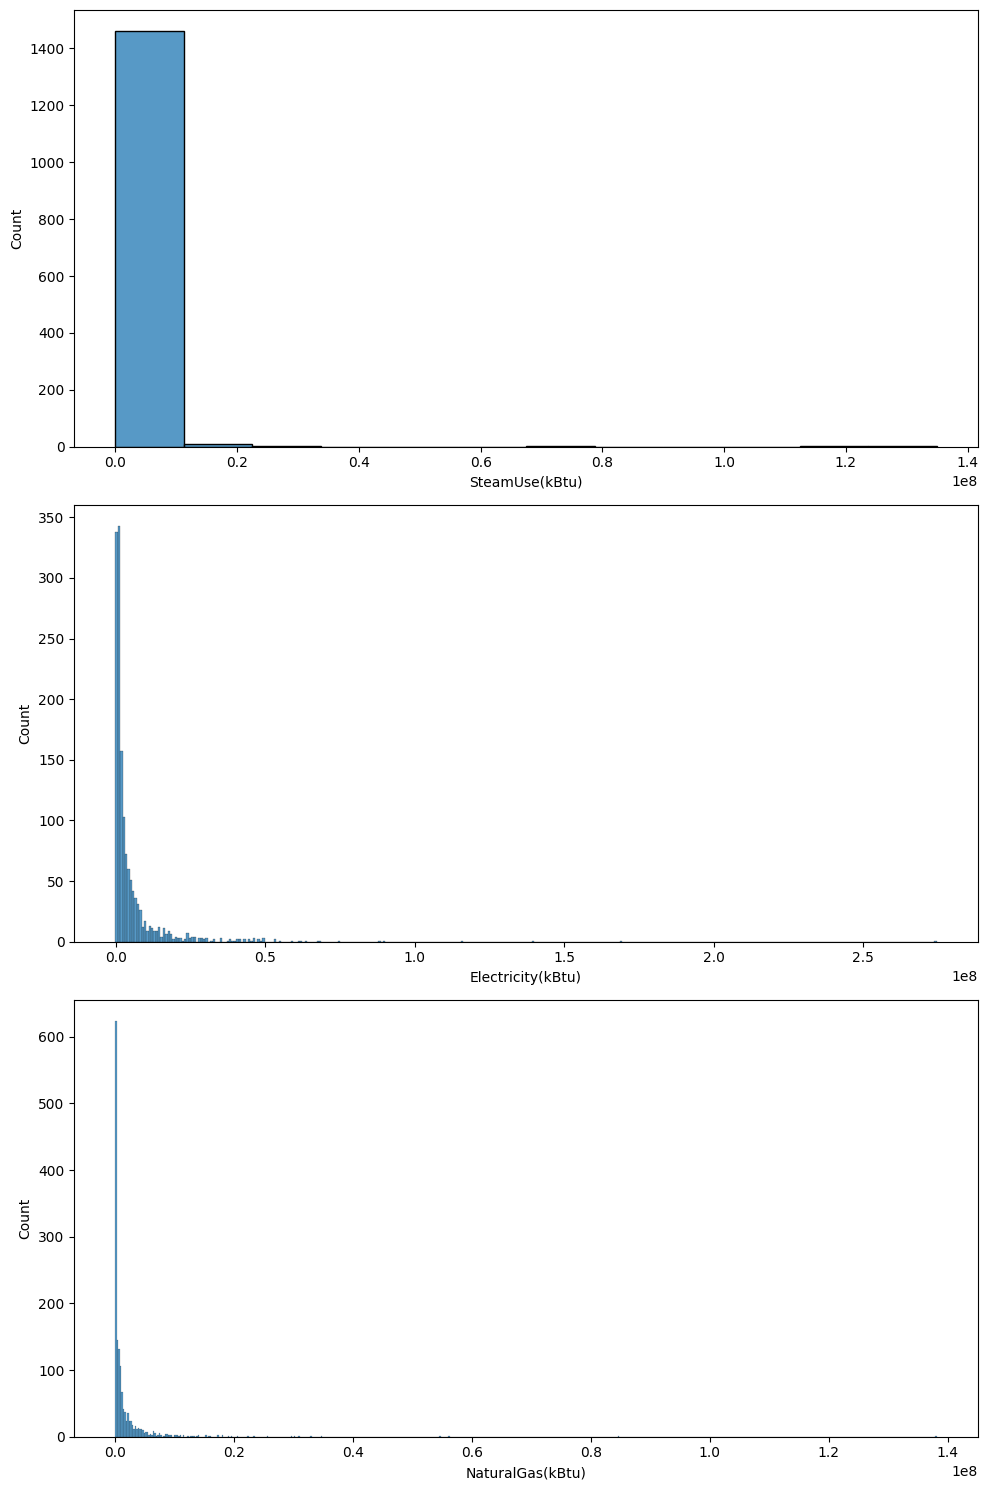

In [813]:
# Variables de consommation énergétique
L_num = ['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']
fig, axes = plt.subplots(nrows=len(L_num), ncols=1, figsize=(10,15))

for i, col in enumerate(L_num):
  df_graph = df[col]
  sns.histplot(x=df_graph, ax=axes[i])

plt.tight_layout()
plt.show()

##**B. Analyse bivariée**

###**1. Matrice de corrélation en heatmap**

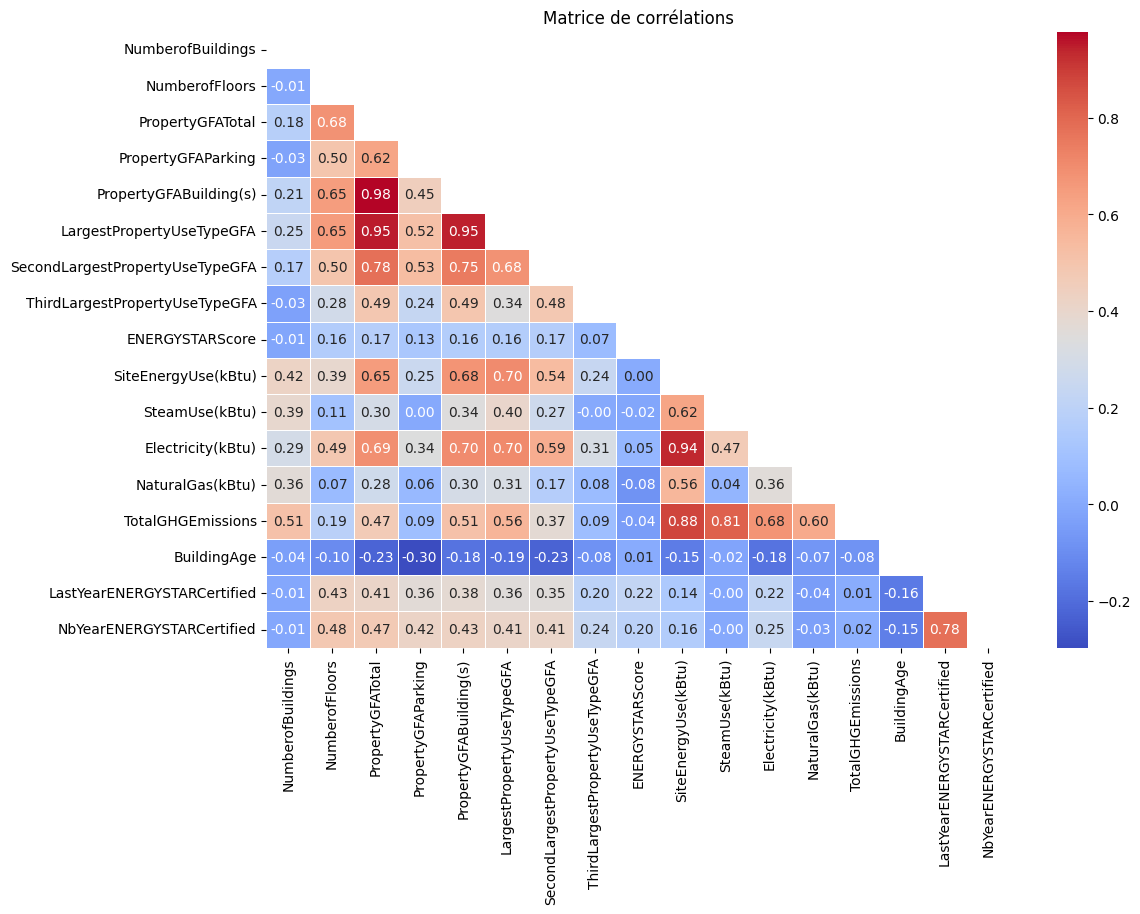

In [814]:
# correlation
NUMERIC_FEATURES = [
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions',
       'BuildingAge', 'LastYearENERGYSTARCertified', 'NbYearENERGYSTARCertified']
plt.figure(figsize=(12, 8))

correlation_matrix = df[NUMERIC_FEATURES].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matrice de corrélations')
plt.show()

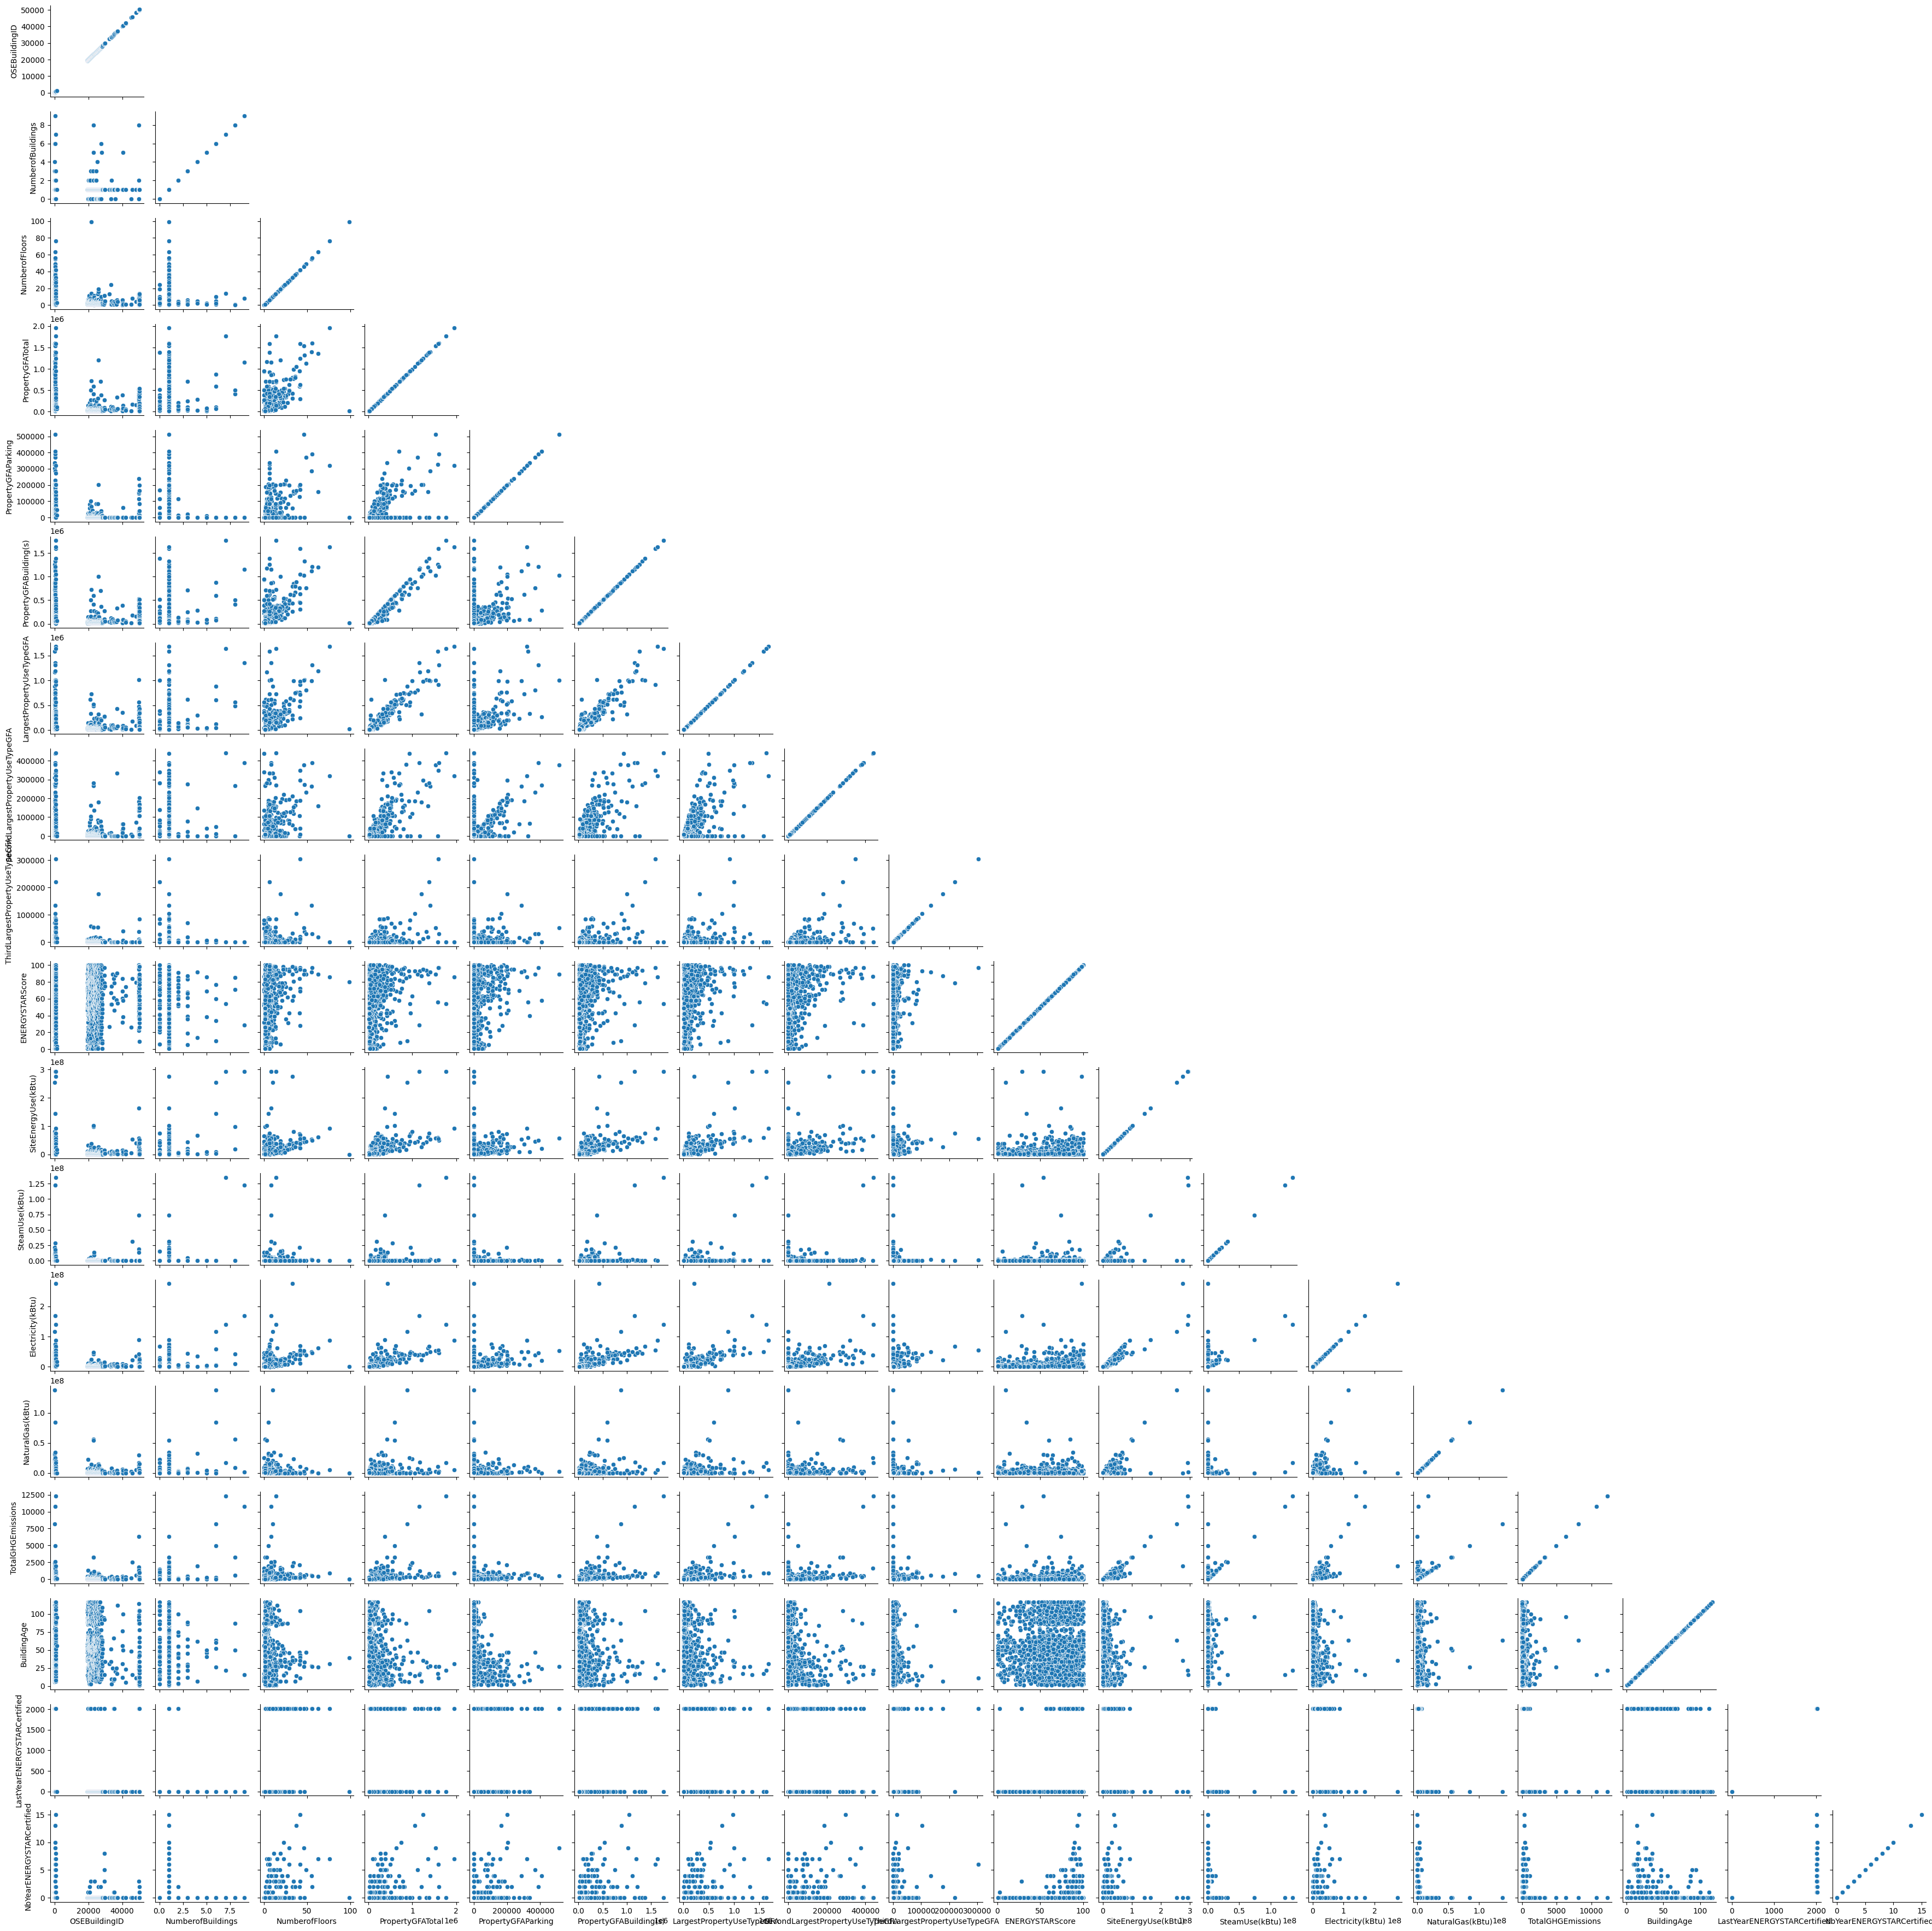

In [815]:
# nuage de points entre les variables quantitatives
sns.pairplot(df, height=2, diag_kind= None, corner=True)
plt.show()

Les variables de surface totale et de surface totale de l'utilisation principale d'une propriété sont naturellement corrélées car

La surface de l'usage principale d'une propriété représente souvent un grand pourcentage de la surface totale. D'où la forte corrélation entre ces variables.

Le raisonnement est similaire pour le nombre de bâtiments. Plus il y a de batiments, plus la surface totale est grande.

On note également une forte corrélation entre la consommation en électricité avec la consommation énergétique et l'émission de carbonne avec la consommation en électricité et la consommation d'énergie sous forme de thermique.

###**2. Variable cible selon le type d'usage, le quartier et l'âge des bâtiments**

In [816]:
# Emissions de carbone par type de batiment
# Emissions de carbone par quartier
# Emissions de carbone selon l'âge du bâtiment
GHGEmissions_per_usage = df.groupby(['LargestPropertyUseType']).agg({'TotalGHGEmissions': 'mean'})
GHGEmissions_per_usage.sort_values(by='TotalGHGEmissions', ascending=False, inplace=True)
print(GHGEmissions_per_usage.head(10), end='\n\n')

GHGEmissions_per_neighborhood = df.groupby(['Neighborhood']).agg({'TotalGHGEmissions': 'mean'})
GHGEmissions_per_neighborhood.sort_values(by='TotalGHGEmissions', ascending=False, inplace=True)
print(GHGEmissions_per_neighborhood.head(10))

                                       TotalGHGEmissions
LargestPropertyUseType                                  
Hospital (General Medical & Surgical)        5052.963000
Courthouse                                   1265.290000
Laboratory                                    815.766154
Data Center                                   807.266667
Lifestyle Center                              539.965000
Urgent Care/Clinic/Other Outpatient           512.062500
Hotel                                         386.380789
Senior Care Community                         371.899500
Police Station                                301.810000
Other - Entertainment/Public Assembly         299.825238

                       TotalGHGEmissions
Neighborhood                            
EAST                          488.545182
DOWNTOWN                      215.744497
NORTHEAST                     204.212121
CENTRAL                       192.039286
LAKE UNION                    174.004101
SOUTHWEST                   

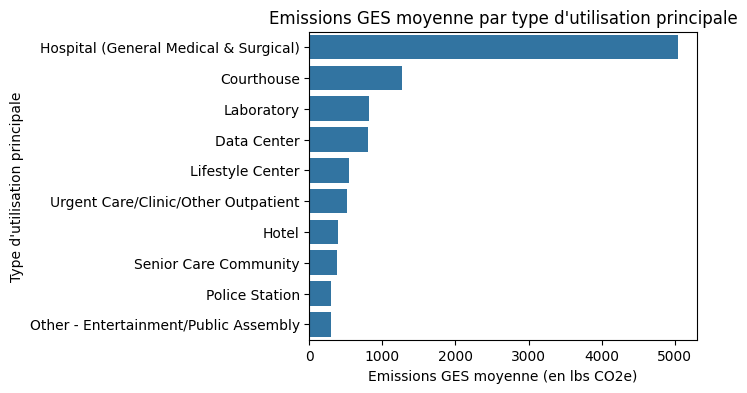

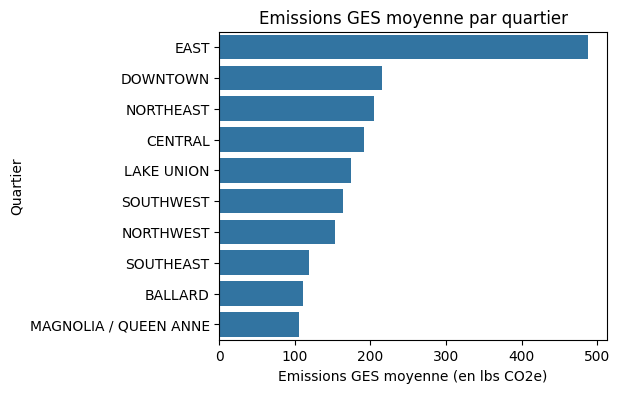

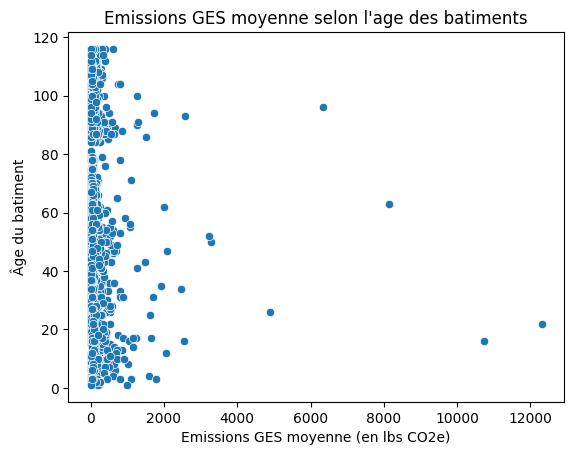

In [817]:
# par usage
plt.figure(figsize=(5, 4))
conso_values = GHGEmissions_per_usage['TotalGHGEmissions'].head(10)
TOP10_GHG_USAGE_TYPES = conso_values.index
sns.barplot(x=conso_values, y=TOP10_GHG_USAGE_TYPES)
plt.ylabel('Type d\'utilisation principale')
plt.xlabel('Emissions GES moyenne (en lbs CO2e)')
plt.title('Emissions GES moyenne par type d\'utilisation principale')
plt.show()

# par quartier
plt.figure(figsize=(5, 4))
conso_values = GHGEmissions_per_neighborhood['TotalGHGEmissions'].head(10)
TOP10_GHG_NEIGHBORHOOD_NAME = conso_values.index
sns.barplot(x=conso_values, y=TOP10_GHG_NEIGHBORHOOD_NAME)
plt.ylabel('Quartier')
plt.xlabel('Emissions GES moyenne (en lbs CO2e)')
plt.title('Emissions GES moyenne par quartier')
plt.show()

# par age
sns.scatterplot(x=df['TotalGHGEmissions'], y=df['BuildingAge'])
plt.ylabel('Âge du batiment')
plt.xlabel('Emissions GES moyenne (en lbs CO2e)')
plt.title('Emissions GES moyenne selon l\'age des batiments')
plt.show()

In [818]:
# Consommation d'électricité par type de batiment
# Consommation d'électricité par quartier
# Consommation d'électricité selon l'age du batiment
conso_per_usage = df.groupby(['LargestPropertyUseType']).agg({'SiteEnergyUse(kBtu)': 'mean'})
conso_per_usage.sort_values(by='SiteEnergyUse(kBtu)', ascending=False, inplace=True)
print(conso_per_usage.head(10), end='\n\n')

conso_per_neighborhood = df.groupby(['Neighborhood']).agg({'SiteEnergyUse(kBtu)': 'mean'})
conso_per_neighborhood.sort_values(by='SiteEnergyUse(kBtu)', ascending=False, inplace=True)
print(conso_per_neighborhood.head(10))

                                       SiteEnergyUse(kBtu)
LargestPropertyUseType                                    
Hospital (General Medical & Surgical)         1.415470e+08
Data Center                                   1.154671e+08
Courthouse                                    4.498447e+07
Laboratory                                    2.736661e+07
Urgent Care/Clinic/Other Outpatient           2.527676e+07
Lifestyle Center                              1.952247e+07
Parking                                       1.530626e+07
Other - Mall                                  1.525270e+07
Wholesale Club/Supercenter                    1.342408e+07
Other - Entertainment/Public Assembly         1.269429e+07

                       SiteEnergyUse(kBtu)
Neighborhood                              
EAST                          1.436411e+07
DOWNTOWN                      1.231341e+07
LAKE UNION                    9.525012e+06
NORTHEAST                     8.657265e+06
CENTRAL                       7.2

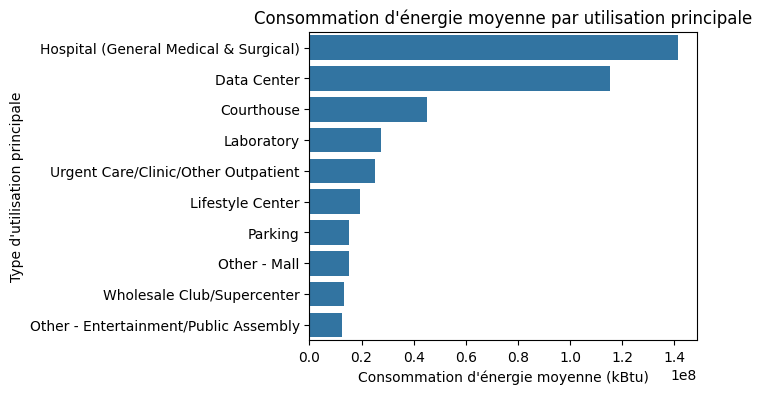

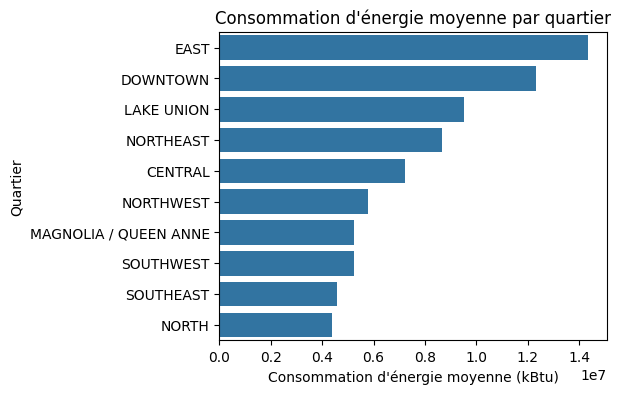

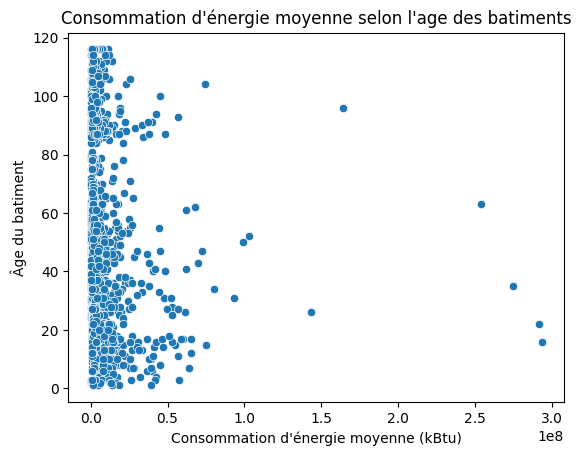

In [819]:
# par usage
plt.figure(figsize=(5, 4))
conso_values = conso_per_usage['SiteEnergyUse(kBtu)'].head(10)
TOP10_ELEC_USAGE_TYPES = conso_values.index
sns.barplot(x=conso_values, y=TOP10_ELEC_USAGE_TYPES)
plt.ylabel('Type d\'utilisation principale')
plt.xlabel('Consommation d\'énergie moyenne (kBtu)')
plt.title('Consommation d\'énergie moyenne par utilisation principale')
plt.show()

# par quartier
plt.figure(figsize=(5, 4))
conso_values = conso_per_neighborhood['SiteEnergyUse(kBtu)'].head(10)
TOP10_ELEC_NEIGHBORHOOD_NAME = conso_values.index
sns.barplot(x=conso_values, y=TOP10_ELEC_NEIGHBORHOOD_NAME)
plt.ylabel('Quartier')
plt.xlabel('Consommation d\'énergie moyenne (kBtu)')
plt.title('Consommation d\'énergie moyenne par quartier')
plt.show()

# par age
sns.scatterplot(x=df['SiteEnergyUse(kBtu)'], y=df['BuildingAge'])
plt.ylabel('Âge du batiment')
plt.xlabel('Consommation d\'énergie moyenne (kBtu)')
plt.title('Consommation d\'énergie moyenne selon l\'age des batiments')
plt.show()

###**3. Mix énergétique selon le type d'usage et le quartier**

In [820]:
# Emissions de carbone par type de batiment
# Emissions de carbone par quartier
energyMix_per_usage = df.groupby(['LargestPropertyUseType']).agg({'SteamUse(kBtu)': 'mean', 'Electricity(kBtu)': 'mean', 'NaturalGas(kBtu)': 'mean'})
energyMix_per_usage.sort_values(by='Electricity(kBtu)', ascending=False, inplace=True)
print(energyMix_per_usage.head(10), end='\n\n')

energyMix_per_neighborhood = df.groupby(['Neighborhood']).agg({'SteamUse(kBtu)': 'mean', 'Electricity(kBtu)': 'mean', 'NaturalGas(kBtu)': 'mean'})
energyMix_per_neighborhood.sort_values(by='Electricity(kBtu)', ascending=False, inplace=True)
print(energyMix_per_neighborhood.head(10))

                                       SteamUse(kBtu)  Electricity(kBtu)  \
LargestPropertyUseType                                                     
Data Center                              0.000000e+00       1.154172e+08   
Hospital (General Medical & Surgical)    3.314040e+07       7.071191e+07   
Courthouse                               0.000000e+00       2.435783e+07   
Urgent Care/Clinic/Other Outpatient      1.774415e+06       1.892032e+07   
Laboratory                               2.386938e+06       1.506648e+07   
Parking                                  0.000000e+00       1.333621e+07   
Other - Mall                             0.000000e+00       1.320405e+07   
Lifestyle Center                         0.000000e+00       1.076910e+07   
Wholesale Club/Supercenter               0.000000e+00       1.030730e+07   
Other - Entertainment/Public Assembly    1.181804e+06       8.730731e+06   

                                       NaturalGas(kBtu)  
LargestPropertyUseType       

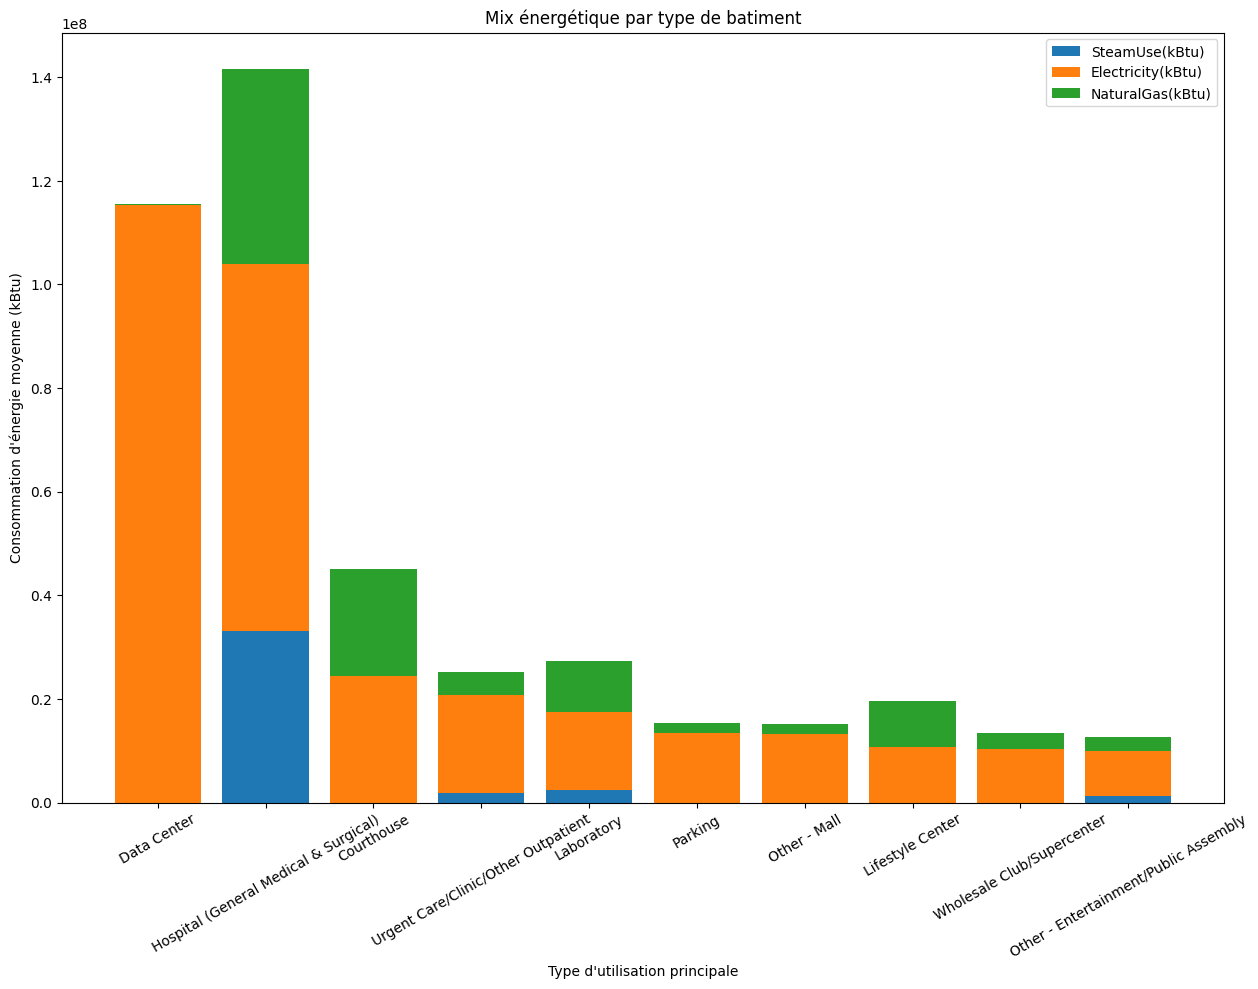

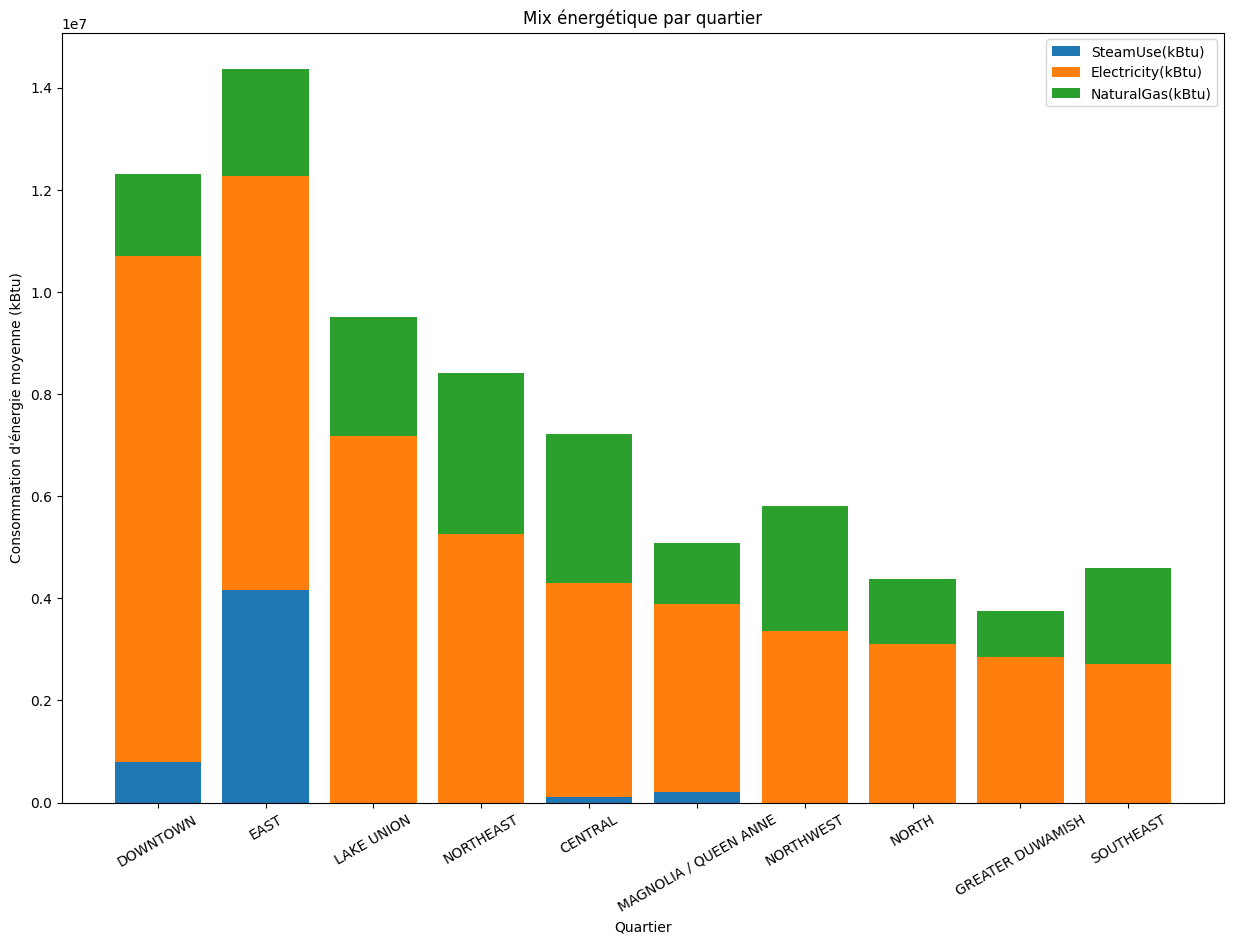

In [821]:
# Mix énergétique par type de batiment
plt.figure(figsize=(15, 10))
conso_values = energyMix_per_usage[['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']].head(10)
usage_types = conso_values.index

bottom = None
for col in conso_values.columns:
    plt.bar(usage_types, conso_values[col], label=col, bottom=bottom)
    if bottom is None:
        bottom = conso_values[col]
    else:
        bottom += conso_values[col]
plt.xlabel('Type d\'utilisation principale')
plt.xticks(rotation=30)
plt.ylabel('Consommation d\'énergie moyenne (kBtu)')
plt.title('Mix énergétique par type de batiment')
plt.legend()
plt.show()


# Mix énergétique par quartier
plt.figure(figsize=(15, 10))
conso_values = energyMix_per_neighborhood[['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']].head(10)
neighborhood_name = conso_values.index

bottom = None
for col in conso_values.columns:
    plt.bar(neighborhood_name, conso_values[col], label=col, bottom=bottom)
    if bottom is None:
        bottom = conso_values[col]
    else:
        bottom += conso_values[col]
plt.xlabel('Quartier')
plt.xticks(rotation=30)
plt.ylabel('Consommation d\'énergie moyenne (kBtu)')
plt.title('Mix énergétique par quartier')
plt.legend()
plt.show()

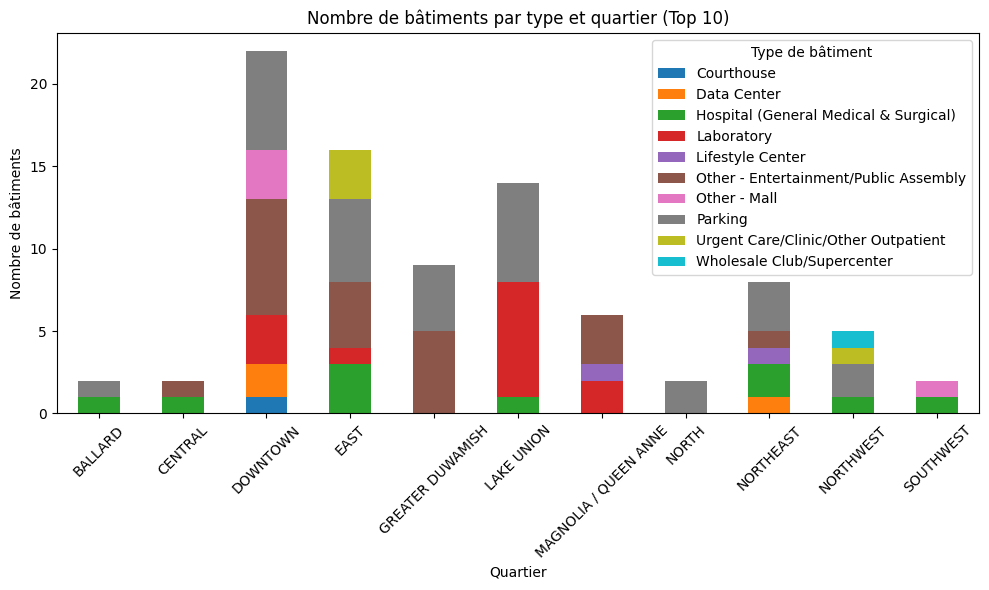

In [822]:
#  # Grouper les batiments selon la Localisation et le TypeDeBatiment

# Limiter les modalités de LargestPropertyUseType aux 10 qui consomment le plus d'énergie
df_graph = df[df['LargestPropertyUseType'].isin(TOP10_ELEC_USAGE_TYPES)]

# Grouper les bâtiments selon la Localisation et le TypeDeBatiment
aggregated_info = df_graph.groupby(['Neighborhood', 'LargestPropertyUseType']).size().unstack(fill_value=0)

# Afficher les informations agrégées sous forme d'histogramme
aggregated_info.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Quartier')
plt.ylabel('Nombre de bâtiments')
plt.title('Nombre de bâtiments par type et quartier (Top 10)')
plt.legend(title='Type de bâtiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###**4. Cas du score énergétique**

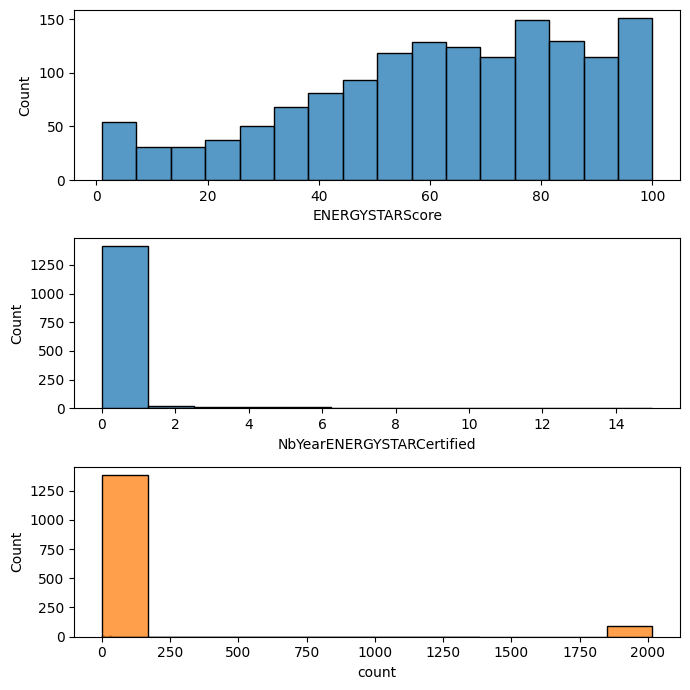

In [823]:
# Univarié
L_num = ['ENERGYSTARScore', 'NbYearENERGYSTARCertified', 'LastYearENERGYSTARCertified']
fig, axes = plt.subplots(nrows=len(L_num), ncols=1, figsize=(7,7))

for i, col in enumerate(L_num):
  df_graph = df[col]
  if col == 'LastYearENERGYSTARCertified':
    sns.histplot(x=df_graph.value_counts(), ax=axes[i])
  sns.histplot(x=df_graph, ax=axes[i])
plt.tight_layout()
plt.show()

In [824]:
# Bivariée
## Energy Star Score par type de batiment
## Energy Star Score par quartier
## Energy Star Score selon l'age des batiments
energyStar_per_usage = df.groupby(['LargestPropertyUseType']).agg({'ENERGYSTARScore': 'mean'})
energyStar_per_usage.sort_values(by='ENERGYSTARScore', ascending=False, inplace=True)
print(energyStar_per_usage.head(10), end='\n\n')

energyStar_per_neighborhood = df.groupby(['Neighborhood']).agg({'ENERGYSTARScore': 'mean'})
energyStar_per_neighborhood.sort_values(by='ENERGYSTARScore', ascending=False, inplace=True)
print(energyStar_per_neighborhood.head(10))

                                                    ENERGYSTARScore
LargestPropertyUseType                                             
Data Center                                               98.000000
Personal Services (Health/Beauty, Dry Cleaning,...        87.333333
Courthouse                                                76.000000
Fire Station                                              75.666667
Pre-school/Daycare                                        73.666667
Adult Education                                           70.333333
Laboratory                                                69.025641
Office                                                    68.445592
College/University                                        67.870370
Parking                                                   67.643678

                       ENERGYSTARScore
Neighborhood                          
DOWNTOWN                     67.693462
NORTHWEST                    66.441441
LAKE UNION                 

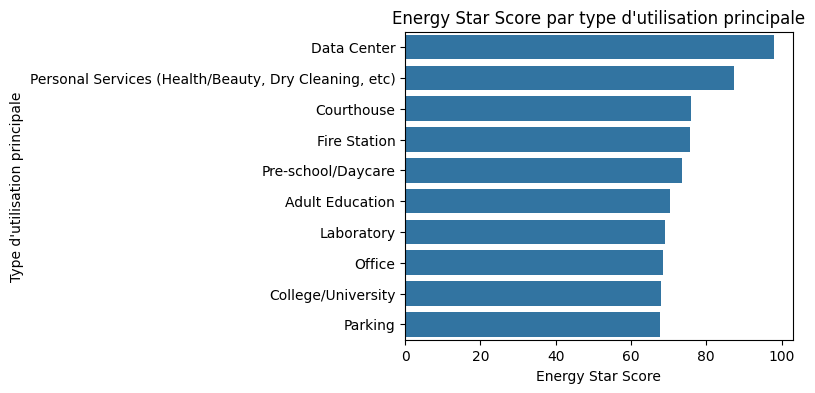

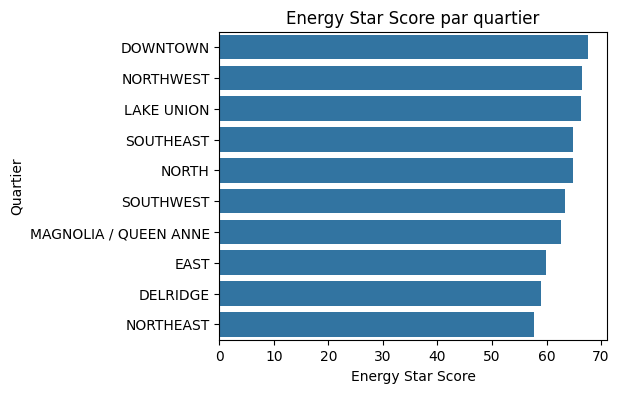

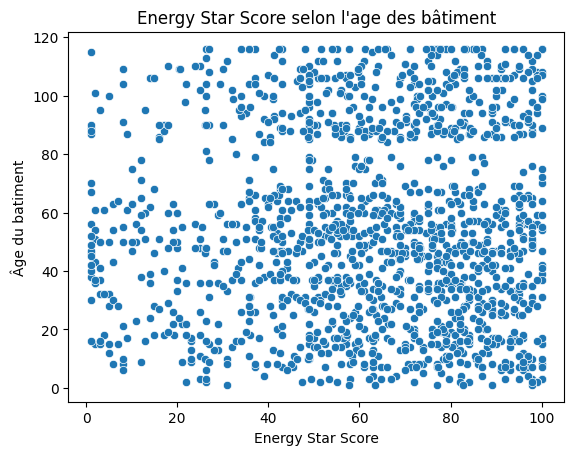

In [825]:
# par usage
plt.figure(figsize=(5, 4))
conso_values = energyStar_per_usage['ENERGYSTARScore'].head(10)
TOP10_GHG_USAGE_TYPES = conso_values.index

sns.barplot(x=conso_values, y=TOP10_GHG_USAGE_TYPES)

plt.ylabel('Type d\'utilisation principale')
plt.xlabel('Energy Star Score')
plt.title('Energy Star Score par type d\'utilisation principale')
plt.show()

# par quartier
plt.figure(figsize=(5, 4))
conso_values = energyStar_per_neighborhood['ENERGYSTARScore'].head(10)
TOP10_GHG_NEIGHBORHOOD_NAME = conso_values.index

sns.barplot(x=conso_values, y=TOP10_GHG_NEIGHBORHOOD_NAME)

plt.ylabel('Quartier')
plt.xlabel('Energy Star Score')
plt.title('Energy Star Score par quartier')
plt.show()

# par age
sns.scatterplot(x=df['ENERGYSTARScore'], y=df['BuildingAge'])
plt.ylabel('Âge du batiment')
plt.xlabel('Energy Star Score')
plt.title('Energy Star Score selon l\'age des bâtiment')
plt.show()

In [826]:
# Exporter le fichier nettoyé
df.to_parquet('/content/drive/MyDrive/openclassrooms/project_list/project_4/data/cleaned_2016_Building_Energy_Benchmarking.pq')